In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import os, imutils
from PIL import Image
from tqdm import tqdm 

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import shuffle
from sklearn import decomposition
from scipy.spatial import distance as dist

from keras.utils import to_categorical
from keras.applications import InceptionV3
from keras.models import Model, Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D, SeparableConv2D, Dropout, BatchNormalization, Flatten, Input, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


### Visualize Some Images

In [2]:
train_dataset_path = "/home/hasan/Desktop/Code to keep on Github/Blood Cell Classification/dataset2-master/images/TRAIN" 

CATEGORIES    = ['EOSINOPHIL','LYMPHOCYTE','MONOCYTE','NEUTROPHIL']

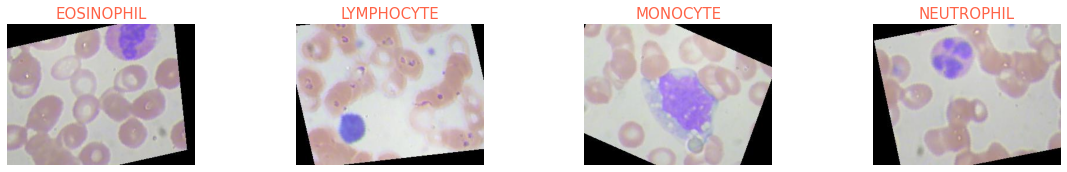

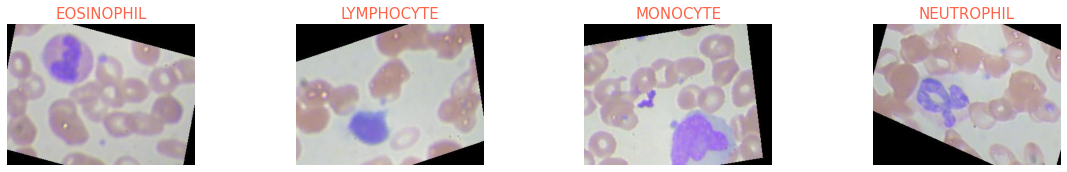

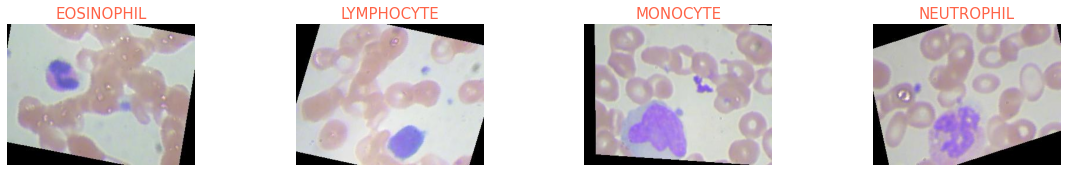

In [3]:
for k in range(3):
    i=0
    plt.figure(figsize=(25,15))
    for category in CATEGORIES:
        plt.subplot(5, 5, i+1)
        plt.yticks([])
        plt.xticks([])
        path=train_dataset_path + '/' + category
        image_p=os.listdir(path)
        plt.title(category , color='tomato').set_size(15)
        plt.axis('off')
        image = cv2.imread(os.path.join(path, image_p[k])) 
        image = image[:, :, [2, 1, 0]] 
        plt.imshow(image)
        i+=1
        

### Loading Dataset

In [4]:
DATADIR = ['/home/hasan/Desktop/Code to keep on Github/Blood Cell Classification/dataset2-master/images/TRAIN', '/home/hasan/Desktop/Code to keep on Github/Blood Cell Classification/dataset2-master/images/TEST']
CATEGORIES = ['EOSINOPHIL','LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

In [5]:
def findEdges(image):
    # find edges in image
    gray = cv2.GaussianBlur(image, (1, 1), 0)
    edged = cv2.Canny(gray, 100, 400)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)
    return edged

def getImgContours(edged):
    # find contours in the edge map
    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sorted(contours, key=lambda x: cv2.contourArea(x))
    return contours

def getBoxes(contours, orig):
    # get the boxes
    boxes = []
    centers = []
    for contour in contours:
        box = cv2.minAreaRect(contour)
        box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
        box = np.array(box, dtype="int")
        (tl, tr, br, bl) = box
        if (dist.euclidean(tl, bl)) > 0 and (dist.euclidean(tl, tr)) > 0:
            boxes.append(box)
    return boxes


In [6]:
training_data = []

def create_training_data():
    for datadir in DATADIR:
        for categories in CATEGORIES:
            path = os.path.join(datadir, categories)
            n_class = CATEGORIES.index(categories)
            for images in os.listdir(path):
                try:
                    image = cv2.imread(os.path.join(path, images))
                    
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    
                    # add padding to the image to better detect cell at the edge
                    image = cv2.copyMakeBorder(image,10,10,10,10, cv2.BORDER_CONSTANT,value=[198, 203, 208])
                  
                    #thresholding the image to get the target cell
                    image1 = cv2.inRange(image,(80, 80, 180),(180, 170, 245))
                    
                    # openning errosion then dilation
                    kernel = np.ones((3, 3), np.uint8)
                    kernel1 = np.ones((5, 5), np.uint8)
                    img_erosion = cv2.erode(image1, kernel, iterations=2)
                    image1 = cv2.dilate(img_erosion, kernel1, iterations=5)
                    
                    #detecting the blood cell
                    edgedImage = findEdges(image1)
                    edgedContours = getImgContours(edgedImage)
                    edgedBoxes =  getBoxes(edgedContours, image.copy())
                    if len(edgedBoxes)==0:
                        count +=1
                        continue
                    # get the large box and get its cordinate
                    last = edgedBoxes[-1]
                    max_x = int(max(last[:,0]))
                    min_x = int( min(last[:,0]))
                    max_y = int(max(last[:,1]))
                    min_y = int(min(last[:,1]))
                
                    # draw the contour and fill it 
                    mask = np.zeros_like(image)
                    cv2.drawContours(mask, edgedContours, len(edgedContours)-1, (255,255,255), -1) 
                    
                    # any pixel but the pixels inside the contour is zero
                    image[mask==0] = 0
                
                    # extract th blood cell
                    image = image[min_y:max_y, min_x:max_x]

                    if (np.size(image)==0):
                        count +=1
                        continue
                    

                    image = cv2.resize(image,(128, 128))
                    training_data.append([image, n_class])
                except Exception as e:
                    pass

create_training_data()


### Feature and Label data

In [7]:
feature = []
label = []

for feature_data, label_data in training_data:
    feature.append(feature_data)
    label.append(label_data)

print(len(feature), len(label))

12146 12146


### Converting to Array

In [8]:
feature = np.array(feature)
label = np.array(label)
print(feature.shape, label.shape)

(12146, 128, 128, 3) (12146,)


### Shuffle of Feature and Label dataset

In [9]:
feature, label = shuffle(feature, label, random_state=10)

### Dividing Dataset

In [10]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(feature, label, 
                                                  test_size=0.25, 
                                                  random_state=0)
print(Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape)

(9109, 128, 128, 3) (3037, 128, 128, 3) (9109,) (3037,)


In [11]:
xtest, xvalid, ytest, yvalid = train_test_split(Xtest, Ytest, 
                                                  test_size=0.15, 
                                                  random_state=0)
print(xtest.shape, xvalid.shape, ytest.shape, yvalid.shape)

(2581, 128, 128, 3) (456, 128, 128, 3) (2581,) (456,)


### Visualizing of Train Dataset

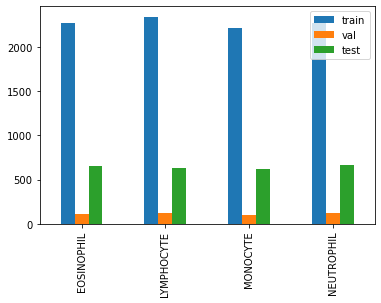

In [12]:
_, train_counts = np.unique(Ytrain, return_counts = True)
_, val_counts = np.unique(yvalid, return_counts = True)
_, test_counts = np.unique(ytest, return_counts = True)

pd.DataFrame({'train': train_counts, "val": val_counts, 'test': test_counts}, index = CATEGORIES).plot.bar()

plt.show()


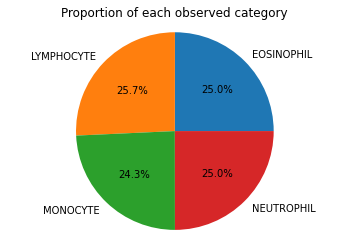

In [13]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0) , 
        labels=CATEGORIES,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

### Normalizing Dataset

In [ ]:
train_images = Xtrain / 255.0 
val_images = xvalid / 255.0
test_images = xtest / 255.0

### Model

In [2]:
model = Sequential()

# First Conv block
model.add(Conv2D(16 , (3,3) , padding = 'same' , activation = 'relu' , input_shape = (128,128,3)))
model.add(Conv2D(16 , (3,3), padding = 'same' , activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

# Second Conv block
model.add(SeparableConv2D(32, (3,3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(32, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

# Third Conv block
model.add(SeparableConv2D(64, (3,3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(64, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

# Forth Conv block
model.add(SeparableConv2D(128, (3,3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(128, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))

# Fifth Conv block 
model.add(SeparableConv2D(256, (3,3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(256, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))


# FC layer 
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'tanh'))
model.add(Dropout(0.7))
model.add(Dense(units = 128 , activation = 'tanh'))
model.add(Dropout(0.5))
model.add(Dense(units = 64 , activation = 'tanh'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(units = 4 , activation = 'softmax'))


In [3]:
# Compile Model
model.compile(optimizer="adam", 
               loss='sparse_categorical_crossentropy', 
               metrics=['accuracy'])


In [4]:
# Summary of the Model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 64, 64, 32)        688       
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 64, 64, 32)        1344      
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0

### Checkpoint and Earlystopping

In [5]:
# Implement callbacks 
checkpoint = ModelCheckpoint(filepath='best_model.hdf5', save_best_only=True, save_weights_only=False)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=3, verbose = 1, mode='min', restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_accuracy', 
    patience = 2, 
    verbose = 1, 
    factor = 0.3, 
    min_lr = 0.000001)


### Training The Model

In [ ]:
# Train
history = model1.fit(
    train_images, 
    Ytrain, 
    batch_size = 32, 
    epochs = 30, 
    validation_data=(val_images, yvalid), 
    callbacks=[learning_rate_reduction])

### Graph of Loss and Accuracy

In [ ]:
epochs = [i for i in range(30)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)
ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()


### Model Saving

In [ ]:
model1.save('Blood_Cell_Classification.h5')

### Model Evaluating

In [ ]:
results = model1.evaluate(test_images, ytest)
print("Loss of the model  is - test ", results[0])
print("Accuracy of the model is - test", results[1]*100, "%")


results = model1.evaluate(val_images, yvalid)
print("Loss of the model  is - val ", results[0])
print("Accuracy of the model is - val", results[1]*100, "%")


results = model1.evaluate(train_images, Ytrain)
print("Loss of the model  is - train ", results[0])
print("Accuracy of the model is - train", results[1]*100, "%")

### Predicting with Test Dataset

In [ ]:
predictions = model1.predict(test_images)
predictions = np.argmax(predictions, axis=1)
predictions


### Classification Report

In [ ]:
print(classification_report(ytest, predictions, 
    target_names = ['EOSINOPHIL (Class 0)', 'LYMPHOCYTE (Class 1)', 'MONOCYTE (Class 2)', 'NEUTROPHIL (Class 3)']))

### Confusion Matrix

In [ ]:
cm = confusion_matrix(ytest, predictions)
cm = pd.DataFrame(cm, index = ['0', '1', '2', '3'], columns = ['0', '1', '2', '3'])
cm


In [ ]:
def plot_confusion_matrix (cm):
    plt.figure(figsize = (10,10))
    sns.heatmap(
        cm, 
        cmap = 'Blues', 
        linecolor = 'black', 
        linewidth = 1, 
        annot = True, 
        fmt = '', 
        xticklabels = CATEGORIES, 
        yticklabels = CATEGORIES)
    
plot_confusion_matrix(cm)
